# Tiny-ResNet-Keras

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

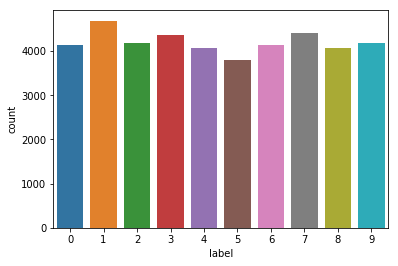

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)

In [5]:
# Split the train and the validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

In [6]:
X_train.shape

(37800, 28, 28, 1)

## Construct the model


- Functional Model

In [17]:
def identity_block(n_output, upscale=False):
    # upscale :whether use the 1x1 conv2d mapping for shortcut or not
    def identity(X):
        #two skip 
        X_shortcut = X
        
        X = Conv2D(kernel_size=(3,3), filters=n_output, strides=(1,1), padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv2D(kernel_size=(3,3), filters=n_output, strides=(1,1), padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        if upscale:
            
            X_shortcut = Conv2D(kernel_size=(1,1), filters=n_output, strides=(1,1), padding='same')(X_shortcut)
            
            X = Add()([X, X_shortcut])
        return X
    
    return identity
        
        
        

In [18]:
def tiny_resnet():
    X_input = Input((28,28,1))
    
    X = Conv2D(kernel_size=3, filters=16, strides=1, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = identity_block(16, True)(X)
    X = identity_block(16, True)(X)
    
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = GlobalMaxPooling2D()(X)
    
    X = Dense(10)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs= X_input, outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [19]:
resnet = tiny_resnet()

In [ ]:
resnet.fit(X_train, Y_train, batch_size=128, epochs=2, validation_data= (X_val, Y_val))

Epoch 1/2
  384/37800 [..............................] - ETA: 367s - loss: 0.5410 - acc: 0.8542

In [23]:
# predict results
results = resnet.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("tiny_resnet.csv",index=False)
